In [1]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [2]:
df = pd.read_csv('train.tsv', sep = '\t')

### EDA and feature selection

In [9]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


#### Price

Price is what we want to predict. First we need to find out how the price values are distributed. 

In [11]:
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

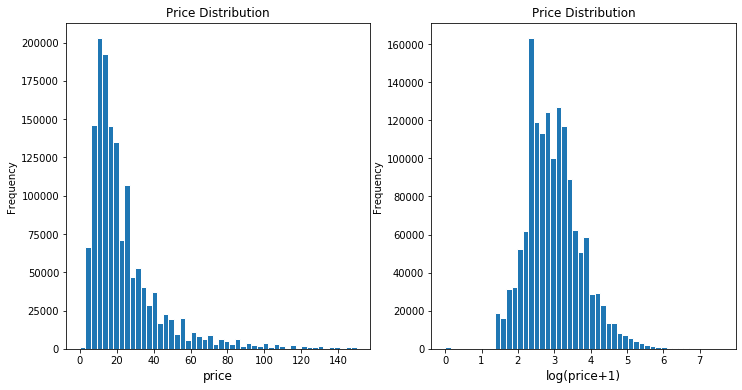

In [13]:
plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 150])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

From the histogram on the left, we can see that the price is skewed, with vast majority of the items priced between 10 to 30. 
The right histogram shows the new distribution after a log transformation has been applied to the price data. 

#### Is shipping related to pricing?

In [15]:
df['shipping'].value_counts() / len(df)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

This shows that over 55% of items shipping fee were paid by the buyers. 

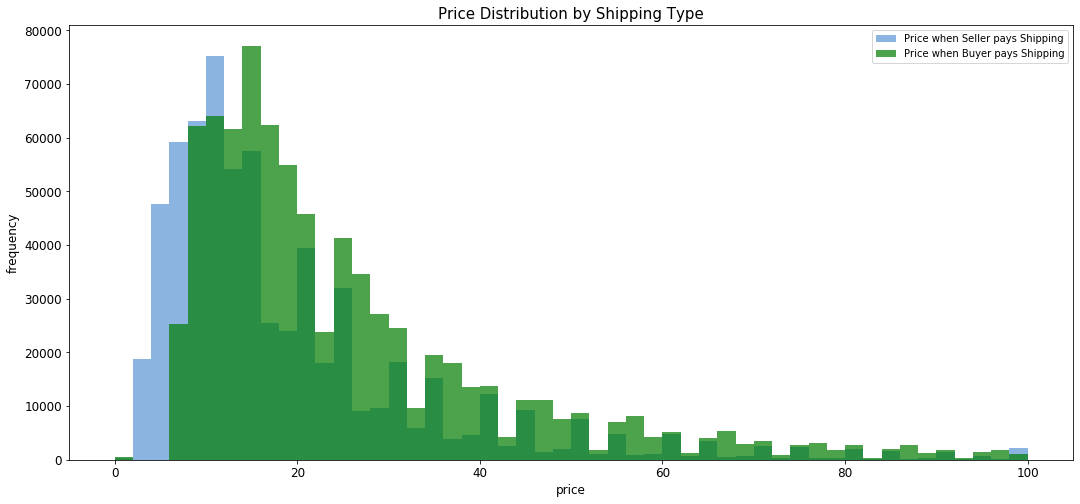

In [16]:
shipping_fee_by_buyer = df.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = df.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [17]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.57 if seller pays shipping
The average price is 30.11 if buyer pays shipping


Results are similar when the price is log-transformed. 

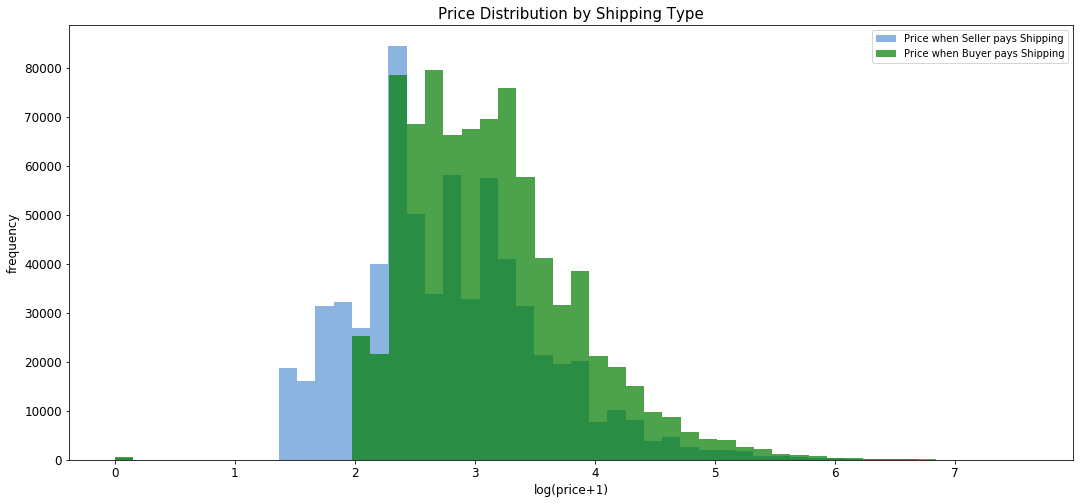

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

So we can safely conclude that the average price is higher when buyer pays shipping

#### Is category names related to pricing?

In [22]:
total_unique_cats = df['category_name'].nunique()

print("The total number of unique categories is: ", total_unique_cats)

The total number of unique categories is:  1287


In [24]:
print("The top 10 most common categories are: ")
df['category_name'].value_counts()[:10]

The top 10 most common categories are: 


Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64

#### Is item condition related to pricing?

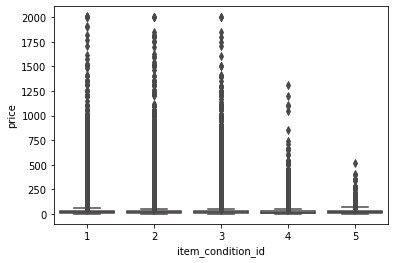

In [33]:
# average price of per item_condition_id
sns.boxplot(x = 'item_condition_id', y = df['price'], 
            data = df, palette = sns.color_palette('RdBu',5))

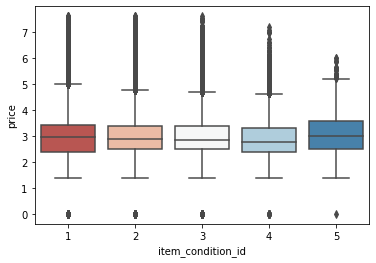

In [35]:
# average log-transformed price per item_condition_id
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), 
            data = train, palette = sns.color_palette('RdBu',5))

Average price varies across item conditions. 

#### All the above features should be included for building the predictive model for pricing

### Build the model with LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages: 
1. Faster training speed and higher efficiency
2. Lower memory usage
3. Parallel and GPU learning supported
4. Capable of handling large-scale data

In [39]:
# General setting
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [45]:
# Handling missing values 
print('There are %d items that do not have a category name.' 
      %df['category_name'].isnull().sum())
print('There are %d items that do not have a brand name.' 
      %df['brand_name'].isnull().sum())
print('There are %d items that do not have a description.' 
      %df['item_description'].isnull().sum())

There are 6327 items that do not have a category name.
There are 632682 items that do not have a brand name.
There are 4 items that do not have a description.


In [44]:
# Helper function for LightGBM
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
    
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [46]:
# Drop rows where price = 0
df_new = df[df.price != 0].reset_index(drop=True)

In [48]:
# split data into training and test set
msk = np.random.rand(len(df)) < 0.7
X_train = df[msk]
X_test = df[~msk]
train.shape, test.shape

((1037692, 8), (444843, 8))

In [49]:
X_test = test.drop('price', axis=1)
y_test = np.log1p(test["price"])

In [50]:
# Merge training and test data
nrow_train = X_train.shape[0]
y = np.log1p(X_train["price"])
merge: pd.DataFrame = pd.concat([X_train, X_test])

/Applications/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



#### Training preparation using the helper functions

In [52]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

Count vectorize name and category name columns.


In [54]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

TF-IDF Vectorize item_description column.

In [55]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [56]:
# label binarize brand_name column 
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [58]:
# Create dummy variables for item_condition_id and shipping columns.
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

TypeError: no supported conversion for types: (dtype('O'),)

In [59]:
# Create sparse merge.
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

NameError: name 'X_dummies' is not defined

In [ ]:
# Remove features with document frequency <=1.
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

# Separate train and test data from sparse merge.
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

# Specify our parameters as a dict.
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

1. Use ‘regression’ as application as we are dealing with a regression problem.
2. Use ‘RMSE’ as metric because this is a regression problem.
3. “num_leaves”=100 as our data is relative big.
4. Use “max_depth” to avoid overfitting.
5. Use “verbosity” to control the level of LightGBM’s verbosity (<0: Fatal).
6. “learning_rate” determines the impact of each tree on the final outcome.

##### Start training

In [ ]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

##### Use trained model to make prediction

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

##### Evaluate the trained model

In [ ]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)